<b><center>DATASET PREPARATION</center></b>

The [dataset](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427) used for our brain tumor classification model is published by Jun Chen.

More information about the dataset:
<p align = 'justify'>It contains 3064 T1-weighted contrast-inhanced MRI images of patients with three kinds of brain tumor: meningioma (708 slices),  glioma (1426 slices), and pituitary tumor (930 slices).</p>

---
This data is organized in matlab data format (.mat file). Each file stores a struct containing the following fields for an image:

<b>cjdata.label</b> : 1 for meningioma, 2 for glioma, 3 for pituitary tumor 

* <b>cjdata.PID</b> : patient ID
* <b>cjdata.image</b> : image data
* <b>cjdata.tumorBorder</b> : a vector storing the coordinates of discrete points on tumor border
* <b>cjdata.tumorMask</b> : a binary image with 1s indicating tumor region

<p align = 'justify'>We have also added one other category which contains MRI images of patients with no tumors to make the model predict whether the patients are having brain tumors or not to make the model cater to broader categories of classification.</p>

###DATASET PREPARATION

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install SimpleITK
!pip install pydicom
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [ ]:
import pydicom
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import glob
from skimage import morphology
from scipy import ndimage
import csv
import torchvision.transforms as T
from PIL import Image
import pickle

import torch
from torch.utils.data import Dataset
#from torchvision import transforms


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
#from data_set import BrainTumorDataset

from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
import seaborn as sns



In [3]:
class base_object():
  pass

globNames = base_object()
globNames.no_classes = 2
globNames.batch_size = 2
globNames.image_size = 128
globNames.model = 'resnet50' # others are resnet152 or resnet18
globNames.epochs = 30
globNames.train2test_ratio = .7
#globNames.ROOT = '/content/drive/MyDrive/BrainTumorCT'
globNames.ROOT = os.getcwd()
globNames.data_path          = os.path.join(globNames.ROOT, 'data_CTtraining')
globNames.processed_data_path= os.path.join(globNames.data_path, 'data_jpg')
globNames.raw_data_path      = os.path.join(globNames.data_path, 'training')
globNames.CSV_path_orig      = os.path.join(globNames.data_path, 'annotations.csv')
globNames.CSV_path_aug       = os.path.join(globNames.data_path, 'annotations_aug.csv')
globNames.pickle_path_train  = os.path.join(globNames.data_path, 'training_data.pickle')
globNames.pickle_path_test   = os.path.join(globNames.data_path, 'testing_data.pickle')


In [ ]:
#!rm rf '/content/drive/MyDrive/Colab Notebooks/dataset'
if not os.path.exists(globNames.ROOT):
  os.mkdir(globNames.ROOT)

if not os.path.exists(data_path):
  os.mkdir(data_path)

if not os.path.exists(globNames.processed_data_path):
  os.mkdir(globNames.processed_data_path)

%cd /content/drive/MyDrive/BrainTumorCT
#!gdown https://figshare.com/ndownloader/articles/1512427/versions/5
!gdown https://drive.google.com/u/0/uc?id=1qlmzqAQr2miOIAIWjdZSy_g3dRP28b0q&export=download

/content/drive/MyDrive/BrainTumorCT
Downloading...
From: https://drive.google.com/u/0/uc?id=1qlmzqAQr2miOIAIWjdZSy_g3dRP28b0q
To: /content/drive/MyDrive/BrainTumorCT/CTtraining.zip
100% 1.72G/1.72G [00:16<00:00, 107MB/s] 


In [ ]:
!mv CTtraining.zip '/content/drive/MyDrive/BrainTumorCT/data_CTtraining'
%cd /content/drive/MyDrive/BrainTumorCT/data_CTtraining
!unzip CTtraining.zip
#!zip -r RAW_CTs data_raw

In [ ]:
!rm CTtraining.zip

In [ ]:

def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image


def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image


def remove_noise(file_path, display=False):
    # https://vincentblog.xyz/posts/medical-images-in-python-computed-tomography
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)

    segmentation = morphology.dilation(brain_image, np.ones((5, 5)))
    labels, label_nb = ndimage.label(segmentation)
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    # We don't use the first class since it's the background
    label_count[0] = 0
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()

    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((5, 5)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    # Since the the pixels in the mask are zero's and one's
    # We can multiple the original image to only keep the brain region
    masked_image = mask * brain_image

    if display:
        plt.figure(figsize=(15, 2.5))
        plt.subplot(141)
        plt.imshow(brain_image)
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(142)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title('Final Image')
        plt.axis('off')
    return masked_image


def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0
    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)

    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],

                   top_left[1]:bottom_right[1]]

    return croped_image


def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape
    final_image = np.zeros((new_height, new_width))
    pad_left = int((new_width - width) / 2)
    pad_top = int((new_height - height) / 2)

    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    return final_image


def all_indices(value, qlist):
    indices = []
    idx = -1
    while True:
        try:
            idx = qlist.index(value, idx + 1)
            indices.append(idx)
        except ValueError:
            break
    return indices


def augment_data(image_orig, index_label=None):
    Hi = np.shape(image_orig)[0]
    Wi = np.shape(image_orig)[1]

    image = Image.fromarray(image_orig)
    transformHf = T.RandomHorizontalFlip(p=1)
    transform_20 = T.RandomRotation(degrees=(335, 345))
    transform20 = T.RandomRotation(degrees=(15, 25))
    image20 = transform20(image)
    image_20 = transform_20(image)
    imageHf = transformHf(image)
    imageHf20 = transform20(imageHf)
    imageHf_20 = transform_20(imageHf)
    return [np.array(image20).reshape(Hi, Wi), np.array(image_20).reshape(Hi, Wi),
            np.array(imageHf).reshape(Hi, Wi), np.array(imageHf20).reshape(Hi, Wi),
            np.array(imageHf_20).reshape(Hi, Wi)]


def read_lables(label_path):
    Labels = {'scan': [], 'frame': [], 'Any': [], 'IPH': [], 'IVH': [], 'SAH': [], 'SDH': []}
    # with open('data_CTtraining/annotations.csv', newline='') as csvfile:
    with open(label_path, newline='') as csvfile:
        labelReader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(labelReader)
        scan_counter = 0
        for row in labelReader:
            Labels['scan'].append(row[1])
            Labels['frame'].append(row[0])
            Labels['Any'].append(int(row[2]))
            Labels['IPH'].append(int(row[3]))
            Labels['IVH'].append(int(row[4]))
            Labels['SAH'].append(int(row[5]))
            Labels['SDH'].append(int(row[6]))
    return Labels


def write_lables(label_path, cols=None):
    fieldnames = ['slice_id', 'case_id', 'ANY', 'IPH', 'IVH', 'SAH', 'SDH']
    with open(label_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if cols:
            writer.writerow({fieldnames[0]: cols[0], fieldnames[1]: cols[1],
                             fieldnames[2]: cols[2], fieldnames[3]: cols[3], fieldnames[4]: cols[4],
                             fieldnames[5]: cols[5], fieldnames[6]: cols[6]})
        else:
            writer.writeheader()


In [ ]:

if not os.path.exists(globNames.processed_data_path):
    os.mkdir(globNames.processed_data_path)

CTs = sorted(glob.glob(globNames.raw_data_path + '/*'))

Labels = read_lables(globNames.CSV_path_orig)

imageSizeThreshMax = 131430  # 512*512
imageSizeThreshMin = 21111  # 0


In [ ]:
# !pwd
# %cd /content/drive/MyDrive/BrainTumorCT
# !mkdir -p data_CTtraining
# %cd /content/drive/MyDrive/BrainTumorCT/data_CTtraining
# !mkdir -p data_raw
# !pwd
# !mv -i data_raw/* data_CTtraining/data_raw/

In [ ]:
!rm globNames.CSV_path_aug
counter = 0
#reject_list = []
train_data = []
aug_labels = ['20', '_20', 'Hf', 'Hf20', 'Hf_20']
write_lables(globNames.CSV_path_aug)
for frame_ind in range(len(Labels['frame'])):
    frame_path = os.path.join(globNames.raw_data_path, Labels['scan'][frame_ind], Labels['frame'][frame_ind] + '.dcm')
    frame = remove_noise(frame_path)
    if not((imageSizeThreshMin >= np.sum(frame != 0)) or (np.sum(frame != 0) >= imageSizeThreshMax)):
        #reject_list.append(frame_ind)
        jpg_name = Labels['scan'][frame_ind] + '_' + Labels['frame'][frame_ind] + '.jpg'
        save_path = os.path.join(globNames.processed_data_path, jpg_name)
        frame = cv2.resize(frame, (globNames.image_size*1, globNames.image_size*1), interpolation=cv2.INTER_AREA)
        cv2.imwrite(save_path, frame)

        write_lables(globNames.CSV_path_aug, [Labels['frame'][frame_ind], Labels['scan'][frame_ind], Labels['Any'][frame_ind],
                     Labels['IPH'][frame_ind], Labels['IVH'][frame_ind], Labels['SAH'][frame_ind],
                     Labels['SDH'][frame_ind]])

        if Labels['Any'][frame_ind]:
            # [frame20, frame_20, frameHf, frameHf20, frameHf_20] = augment_data(frame)
            augmentedList = augment_data(frame)
            for index, frame in enumerate(augmentedList):
                frame_tag = Labels['frame'][frame_ind]+ aug_labels[index]
                jpg_name = Labels['scan'][frame_ind] + '_' + frame_tag + '.jpg'
                #train_data.append([aug_frame, 1])
                save_path = os.path.join(globNames.processed_data_path, jpg_name)
                cv2.imwrite(save_path, frame)
                write_lables(globNames.CSV_path_aug, [frame_tag, Labels['scan'][frame_ind], Labels['Any'][frame_ind],
                          Labels['IPH'][frame_ind], Labels['IVH'][frame_ind], Labels['SAH'][frame_ind],
                          Labels['SDH'][frame_ind]])
    # else:
        #reject_list.append(frame_ind)



In [ ]:
Labels = read_lables(globNames.CSV_path_aug)

train_test_data = []
for frame_ind in range(len(Labels['frame'])):
    frame_path = os.path.join(globNames.processed_data_path, Labels['scan'][frame_ind]+'_'+
                              Labels['frame'][frame_ind] + '.jpg')
    frame = cv2.imread(frame_path)
    #frame = cv2.resize(frame, (globNames.image_size, globNames.image_size), interpolation=cv2.INTER_AREA)
    # img2 = cv2.resize(img, (512,512))
    label = [int(not(Labels['Any'][frame_ind])),
                     Labels['Any'][frame_ind], 
                     Labels['IPH'][frame_ind], 
                     Labels['IVH'][frame_ind],
                     Labels['SAH'][frame_ind], 
                     Labels['SDH'][frame_ind]]
    ID = Labels['frame'][frame_ind]
    train_test_data.append([ID, label, frame])




In [ ]:
data_length = len(train_test_data)
print(data_length)
training_length = [0,               round(data_length*0.7)]
testing_length =  [round(data_length*0.7),     data_length]
print(training_length)
print(testing_length)
print(np.shape(train_test_data[0:100]))

12183
[0, 8528]
[8528, 12183]
(100, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:

pickle_out_train = open(globNames.pickle_path_train, "wb")
pickle_out_test = open(globNames.pickle_path_test, "wb")
pickle.dump(train_test_data[training_length[0]:training_length[1]], pickle_out_train)
pickle.dump(train_test_data[testing_length[0]:testing_length[1]], pickle_out_test)
pickle_out_train.close()
pickle_out_test.close()

In [ ]:
train_data[1]

In [ ]:
frame_name = os.path.basename(frame_path).split('.')[0]
scan_name  = os.path.basename(os.path.dirname(frame_path)) 
save_path = os.path.join(scan_name, frame_name)
print(save_path)
print(os.path.basename(os.path.dirname(frame_path)))
print(os.path.abspath(frame_path))

data_jpg/CID_1918b6d8be_ID_4340a8aae
data_jpg
/content/drive/MyDrive/BrainTumorCT/data_CTtraining/data_jpg/CID_1918b6d8be_ID_4340a8aae.jpg



.


.


.


.


.
Now training


.

.

.

.

.








In [4]:
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, no_classes=4, image_size=128):
        # Images
        self.X = images
        # Corresponding Labels
        self.Y = labels

        # Convert original image numpy array to PIL image and then to a tensor
        self.transform = T.Compose([T.ToPILImage(),
                                             T.Resize((image_size, image_size)),
                                             T.ToTensor()
                                             ])
        self.no_classes = no_classes

    def __len__(self):
        # Returns # of images
        return len(self.X)

    def __getitem__(self, idx):
        # Transformations for one image of X at a time
        # Original image as a tensor
        img = self.transform(self.X[idx])
        '''
        # store the transformed images in a list
        batch = [img, img20, img_20, imgHf, imgHf20, imgHf_20]
        '''
        # One Hot Encoding is used here to give the respective column of the image label 1.0 and other columns as 0.0
        labels = torch.zeros(self.no_classes, dtype=torch.float32)
        #labels[self.Y[idx][0]] = 1
        #labels = labels[self.Y[idx]]
        


        
        for i in range(self.no_classes):
          labels[i] = self.Y[idx][i]
        # labels[5] = self.Y[idx][4]        
        # labels[4] = self.Y[idx][3]
        # labels[3] = self.Y[idx][2]
        # labels[2] = self.Y[idx][1]
        # labels[1] = self.Y[idx][0]
        # labels[0] = int(not(self.Y[idx][0]))
        # labels[2] = int(not(self.Y[idx][1]))
        # labels[3] = int(not(self.Y[idx][2]))
        #labels = labels[0]
        #b_labels = [labels, labels, labels, labels, labels, labels]
        labels= [labels]
        img = [img]
        # print(np.shape(img[0]))
        # print(labels)
        # print('GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGg')
        # 8 augmented images and corresponding labels per sample will be returned
        #return (torch.stack(b_labels), torch.stack(batch))
        # print('h')
        return (torch.stack(labels), torch.stack(img))

In [5]:
def save_model(state, is_best, filename=os.path.join(globNames.ROOT, globNames.model + '.pth.tar')):
    torch.save(state, filename)

In [7]:
train_data = pickle.load(open(globNames.pickle_path_train, 'rb'))

test_data = pickle.load(open(globNames.pickle_path_test, 'rb'))


In [8]:

Xt, Yt, label_X, label_Y, IDs_X, IDs_Y= [], [], [], [], [], []
ID, label, image = None, None, None

for ID, label, image in train_data:
    IDs_X.append(ID)
    label_X.append(label)
    Xt.append(image)

ID, label, image = None, None, None
for ID, label, image in test_data:
    IDs_Y.append(ID)
    label_Y.append(label)
    Yt.append(image)    


# X_train, X_test, Y_train, Y_test = train_test_split(Xt, Yt, test_size=0.2, shuffle=True)
# X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.6, shuffle=True)

# print(f"Number of training samples: {len(X_train)}")
# print(f"Number of validation samples: {len(X_val)}")
# print(f"Number of testing samples: {len(X_test)}")

# Xt, Yt, labels, label, features, train_data = None, None, None, None, None, None

train_set = BrainTumorDataset(Xt, label_X, globNames.no_classes)
#val_set = BrainTumorDataset(X_val, Y_val, globNames.no_classes)
test_set = BrainTumorDataset(Yt, label_Y, globNames.no_classes)

train_loader = DataLoader(train_set, batch_size=globNames.batch_size, shuffle=True, pin_memory=True, num_workers=1)
#val_loader = DataLoader(val_set, batch_size=globNames.batch_size, shuffle=True, pin_memory=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=globNames.batch_size, shuffle=True, pin_memory=True, num_workers=1)

In [ ]:
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

if globNames.model == 'resnet50':
  trainingModel = models.resnet50(pretrained=True)
elif globNames.model == 'resnet18':
  trainingModel = models.resnet18(pretrained=True)
elif globNames.model == 'resnet152':
  trainingModel = models.resnet152(pretrained=True)



# Training all parameters
for param in trainingModel.parameters():
    param.requires_grad = True
# Input for fully connected layer
n_inputs = trainingModel.fc.in_features

trainingModel.fc = nn.Sequential(nn.Linear(n_inputs, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, 2048),
                                nn.SELU(),
                                nn.Dropout(p=0.4),
                                nn.Linear(2048, globNames.no_classes),
                                nn.LogSigmoid())


for name, child in trainingModel.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

trainingModel.to(device)

In [ ]:
#trainingModel.load_state_dict(torch.load('/content/drive/MyDrive/BrainTumorCT/bt_resnet50_bt_intermodel.pth.tar'))

In [10]:
crossen_loss = nn.CrossEntropyLoss().to(device)
sgd_opt = torch.optim.SGD(trainingModel.parameters(), momentum=0.9, lr=3e-4)

# Lists to store train, test losses and accuracies
train_losses, val_losses, train_accs, val_accs = [],[],[],[]

best_prec_loss = 2

In [15]:
start_time = time.time()
# Batch Variables
b = None
train_b = None
test_b = None

# Training
for i in range(globNames.epochs):
    # Training Correct and Validation Correct is updated to 0 during every iteration
    train_corr = 0
    val_corr = 0
    # Timing Epoch: starting epoch time
    e_start = time.time()
    # Batch Training
    for b, (y, X) in enumerate(train_loader):
        # Transfer variables to the device if available
        X, y = X.to(device), y.to(device)
        # Forward passing image
        #print(np.shape(X))
        y_pred = trainingModel(X.view(-1, 3, globNames.image_size, globNames.image_size))
        # print('HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH')
        # print(y_pred)
        # print(y)
        # print('######################################################')
        # Loss calculation
        loss = crossen_loss(y_pred.float(), torch.argmax(y.view(-1, globNames.no_classes), dim=1).long())
        # The argmax of the predicted tensor is assigned as our label
        mod_pred = torch.argmax(y_pred, dim=1).data
        # # of correctly predicted images in a batch is equal to the sum of all correctly predicted images
        batch_corr = (mod_pred == torch.argmax(y.view(-1, globNames.no_classes), dim=1)).sum()
        # Batch correct is added to train correct for tracking the # of correctly predicted labels of the training data
        train_corr += batch_corr
        # Setting SGD opt gradient to zero
        sgd_opt.zero_grad()
        # Back propagation based on the loss to update weights to improve learning
        loss.backward()
        # Performing the increment in weights by taking a step
        sgd_opt.step()
    # Epoch end time
    e_end = time.time()
    # Output: Training Metrics
    print(f'Current Epoch: {(i + 1)} Running Batch: {(b + 1) * globNames.batch_size} \nTraining Accuracy: '
          f'{train_corr.item() * 100 / (globNames.batch_size * b):2.2f} %  Training Loss: {loss.item():2.6f}  '
          f'Training Duration: {((e_end - e_start) / 60):.2f} minutes')  # 4 images per batch * 8 augmentations per image * batch length
    # Storing the training losses and correct to plot graph between losses and predicted corrects with batch
    train_b = b
    train_losses.append(loss)
    train_accs.append(train_corr)

    X, y = None, None

    # Validation using val_loader data
    # The backpropagation isn't performed as it is validation data
    with torch.no_grad():
        for b, (y, X) in enumerate(test_loader):
            # set label as cuda if device is cuda
            X, y = X.to(device), y.to(device)

            # forward pass image
            y_val = trainingModel(X.view(-1, 3, globNames.image_size, globNames.image_size))

            # The argmax of the predicted tensor is assigned as our label
            mod_pred = torch.argmax(y_val, dim=1).data
            mod_pred[0]
            # Batch correct is added to validation correct for tracking the # of correctly predicted labels of the validation data
            val_corr += (mod_pred == torch.argmax(y.view(-1, globNames.no_classes), dim=1)).sum()

    # Loss of validation set
    loss = crossen_loss(y_val.float(), torch.argmax(y.view(-1, globNames.no_classes), dim=1).long())
    # Output validation metrics
    print(
        f'Validation Accuracy {val_corr.item() * 100 / (globNames.batch_size * b):2.2f} Validation Loss: {loss.item():2.6f}\n')

    # Saves model if the current validation loss less than the previous validation loss
    best = loss < best_prec_loss
    best_prec_loss = min(loss, best_prec_loss)
    save_model({
        'epoch': i + 1,
        'state_dict': trainingModel.state_dict(),
        'best_prec1': best_prec_loss,
    }, best)

    # Storing the validation losses and correct to plot graph between losses and predicted corrects with batch
    val_b = b
    val_losses.append(loss)
    val_accs.append(val_corr)

# Training process's end time
end_time = time.time() - start_time

# Total training duration
print("\nTraining Duration {:.2f} minutes".format(end_time / 60))

Current Epoch: 1 Running Batch: 8528 
Training Accuracy: 75.63 %  Training Loss: 0.347694  Training Duration: 2.78 minutes
Validation Accuracy 75.31 Validation Loss: 0.540476

Current Epoch: 2 Running Batch: 8528 
Training Accuracy: 77.41 %  Training Loss: 0.000292  Training Duration: 2.78 minutes
Validation Accuracy 79.89 Validation Loss: 0.247053

Current Epoch: 3 Running Batch: 8528 
Training Accuracy: 90.39 %  Training Loss: 0.031090  Training Duration: 2.77 minutes
Validation Accuracy 86.02 Validation Loss: 0.046733

Current Epoch: 4 Running Batch: 8528 
Training Accuracy: 94.68 %  Training Loss: 0.025037  Training Duration: 2.76 minutes
Validation Accuracy 87.74 Validation Loss: 0.023668

Current Epoch: 5 Running Batch: 8528 
Training Accuracy: 96.04 %  Training Loss: 0.003629  Training Duration: 2.78 minutes
Validation Accuracy 89.60 Validation Loss: 6.294924

Current Epoch: 6 Running Batch: 8528 
Training Accuracy: 96.87 %  Training Loss: 0.050808  Training Duration: 2.85 minut

In [35]:
torch.cuda.empty_cache()
torch.save(trainingModel.state_dict(), os.path.join(globNames.ROOT, globNames.model + '_' +
          str(globNames.batch_size) +'_'+ str(globNames.no_classes)+'_'+ str(globNames.epochs)+'.pt'))

In [32]:
#resnet_50.load_state_dict(torch.load('/content/drive/MyDrive/BrainTumorCT/bt_resnet50_bt_intermodel.pth.tar'))
# Stats = torch.load('/content/drive/MyDrive/BrainTumorCT/bt_resnet50_bt_intermodel.pth.tar')
# resnet_50.dict  = (Stats['state_dict'])
#Stats['best_prec1']

tensor(6.7949e-06, device='cuda:0')

In [23]:
y_val = trainingModel(X.view(-1, 3, globNames.image_size, globNames.image_size))
# The argmax of the predicted tensor is assigned as our label
mod_pred = torch.argmax(y_val, dim=1).data
mod_pred[0]
# Batch correct is added to validation correct for tracking the # of correctly predicted labels of the validation data
val_corr += (mod_pred == torch.argmax(y.view(-1, globNames.no_classes), dim=1)).sum()
loss = crossen_loss(y_val.float(), torch.argmax(y.view(-1, globNames.no_classes), dim=1).long())
print(
        f'Validation Accuracy {val_corr.item() * 100 / (globNames.batch_size * b):2.2f} Validation Loss: {loss.item():2.6f}\n')

Validation Accuracy 89.38 Validation Loss: 0.000069



In [21]:
    print(
        f'Validation Accuracy {val_corr.item() * 100 / (globNames.batch_size * b):2.2f} Validation Loss: {loss.item():2.6f}\n')

Validation Accuracy 89.35 Validation Loss: 0.000086



In [26]:
train_losses_cpu = np.zeros(globNames.epochs, dtype=np.float32)
val_losses_cpu = np.zeros(globNames.epochs, dtype=np.float32)

for i in range(len(train_losses)):
  train_losses_cpu[i] = train_losses[i].cpu().data.numpy()
  val_losses_cpu[i] = val_losses[i].cpu().data.numpy()

# print(train_losses_cpu)
# print(val_losses_cpu)

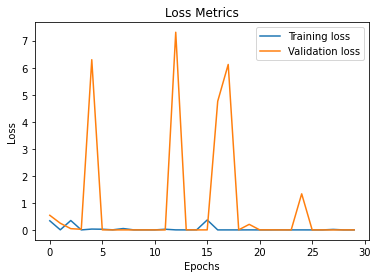

In [27]:
plt.plot(train_losses_cpu, label='Training loss')
plt.plot(val_losses_cpu, label='Validation loss')
plt.title('Loss Metrics')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [28]:
train_accs_cpu = np.zeros(globNames.epochs, dtype=np.float32)
val_accs_cpu = np.zeros(globNames.epochs, dtype=np.float32)

for i in range(len(train_accs_cpu)):
  train_accs_cpu[i] = train_accs[i].data.cpu().numpy()
  val_accs_cpu[i] = val_accs[i].cpu().data.numpy()

# print(train_accs_cpu)
# print(val_accs_cpu)

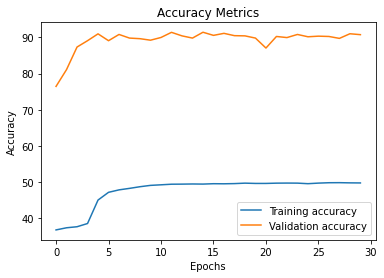

In [29]:
plt.plot([t/171 for t in train_accs_cpu], label='Training accuracy')
plt.plot([t/36 for t in val_accs_cpu], label='Validation accuracy')
plt.title('Accuracy Metrics')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [30]:
train_loader, val_loader, train_set, val_set = None, None, None, None

In [ ]:
# Setting model to evaluation mode
trainingModel.eval()

# No weight updates
with torch.no_grad():
    # some metrics storage for visualization and analysis
    test_pred = 0
    test_loss, test_corr, labels, pred = [],[],[],[]

    # Batch wise test set evaluation
    for (y, X) in test_loader:
        # Use GPU if available
        X, y = X.to(device), y.to(device)
        print('X.shape')
        print(X.shape)
        print('y.shape')
        print(y.shape)
        
        # Original labels
        labels.append(torch.argmax(y.view(globNames.batch_size, globNames.no_classes), dim=1).data)
        print('labels.shape')
        print(labels[0].shape)
        # Forward pass
        y_val = trainingModel(X.view(-1, 3, globNames.image_size,globNames.image_size))
        print('y_val.shape')
        print(y_val.shape)
        print('X.view(-1, 3, globNames.image_size,globNames.image_size)')
        print(X.view(-1, 3, globNames.image_size,globNames.image_size).shape)
        # The argmax of the predicted tensor is assigned as our label
        pred_label = torch.argmax(y_val, dim=1).data
        print('pred_label.shape')
        print(pred_label.shape)
        # Predicted label addition to the list
        pred.append(pred_label)
        print('pred.shape')
        print(pred[0].shape)
        # Compute loss
        loss = crossen_loss(y_val.float(), torch.argmax(y.view(globNames.batch_size, globNames.no_classes), dim=1).long())

        # Adding the total correct predicted per batch to overall correct predictions
        test_pred += (pred_label== torch.argmax(y.view(globNames.batch_size, globNames.no_classes), dim=1)).sum()

        # Storing correct 
        test_corr.append(test_pred)
        test_loss.append(loss)
        
print(f"Test Loss: {test_loss[-1].item():.4f}")

In [32]:
labels = torch.stack(labels)
pred = torch.stack(pred)

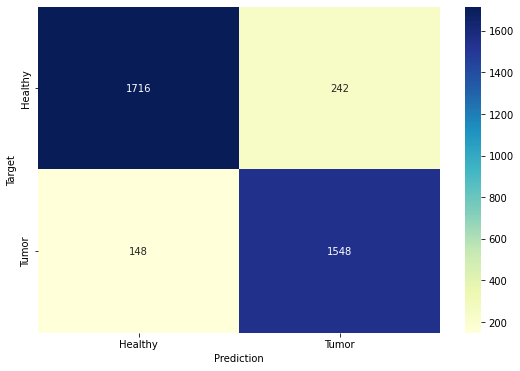

In [33]:
LABELS = ['Healthy', 'Tumor']
conf_matrix = confusion_matrix(pred.view(-1).cpu(), labels.view(-1).cpu())
df_cm = pd.DataFrame(conf_matrix, LABELS, LABELS)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='YlGnBu')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()